### Standard imports and global variables

In [1]:
import ast
import json
import importlib
from pathlib import Path
from functools import reduce
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

spec = importlib.util.spec_from_file_location("utils", "../../src/processing/utils.py")
utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(utils)

In [2]:
FIGURES_DIR = "../../figures/"
TASK_ONE_DATA_PATH = "../../data/raw/user_study_results/dataclips_aolcedkqrfjfehnxrhunrbysyepr.json"
TASK_TWO_DATA_PATH = "../../data/raw/user_study_results/dataclips_gdnjjptpwsyunzmhlqhqsodmmqda.json"
STOCKS_PATH = "../../data/processed/stocks/revolut.2021-07-05.complete.stocks.jsonl"

### Converting raw data to appropriate formats

In [3]:
# Task one
task_one_data = utils.read_json(TASK_ONE_DATA_PATH)
print(task_one_data.keys())

article_evals = pd.DataFrame(task_one_data["values"], columns=task_one_data["fields"])
display(article_evals.head())

# Task two
task_two_data = utils.read_json(TASK_TWO_DATA_PATH)
print(task_two_data.keys())

stock_evals = pd.DataFrame(task_two_data["values"], columns=task_two_data["fields"])
display(article_evals.head())

dict_keys(['title', 'values', 'fields', 'types', 'type_names', 'started_at', 'finished_at', 'checksum'])


,id,doc_id,rating,optional_reasons
0,1,43,rating-3,"['optional-reason-1', 'optional-reason-2', 'op..."
1,2,29,rating-5,[]
2,3,oos_4,rating-5,[]
3,4,oos_8,rating-4,['optional-reason-2']
4,5,11,rating-4,['optional-reason-5']


dict_keys(['title', 'values', 'fields', 'types', 'type_names', 'started_at', 'finished_at', 'checksum'])


,id,doc_id,rating,optional_reasons
0,1,43,rating-3,"['optional-reason-1', 'optional-reason-2', 'op..."
1,2,29,rating-5,[]
2,3,oos_4,rating-5,[]
3,4,oos_8,rating-4,['optional-reason-2']
4,5,11,rating-4,['optional-reason-5']


#### Converting  raw database rating values to Likert scale

In [4]:
def rating_index(rating_value):
    rating_id = rating_value.split("-")[-1]
    if rating_id == "none":
        return np.inf
    else:
        return int(rating_id)

likert_scale_t1 = ["Very Poor", "Poor", "Acceptable", "Good", "Very Good"]
likert_scale_t2 = ["Very Poor", "Poor", "Acceptable", "Good", "Very Good", "Not Sure"]

In [5]:
rating_values = sorted(article_evals.rating.unique(), key=rating_index)
article_evals.rating = (article_evals
                            .rating
                            .map(dict(zip(rating_values, likert_scale_t1)))
                            .astype("category"))
display(article_evals)

,id,doc_id,rating,optional_reasons
0,1,43,Acceptable,"['optional-reason-1', 'optional-reason-2', 'op..."
1,2,29,Very Good,[]
2,3,oos_4,Very Good,[]
3,4,oos_8,Good,['optional-reason-2']
4,5,11,Good,['optional-reason-5']
...,...,...,...,...
456,489,43,Very Good,[]
457,490,44,Very Good,[]
458,491,46,Good,[]
459,492,50,Very Good,[]


In [6]:
rating_values = sorted(stock_evals.rating.unique(), key=rating_index)
stock_evals.rating = (stock_evals
                          .rating
                          .map(dict(zip(rating_values, likert_scale_t2)))
                          .astype("category"))
display(stock_evals)

,id,ticker_symbol,rating,optional_reasons
0,1,HES,Very Good,[]
1,2,AAPL,Very Good,[]
2,3,BABA,Good,[]
3,4,ABEV,Good,[]
4,5,VIPS,Good,[]
...,...,...,...,...
372,405,SSNC,Not Sure,[]
373,406,BIP,Poor,['optional-reason-1']
374,407,SRE,Very Good,[]
375,408,LI,Very Good,[]


#### Converting raw database optional reason values to values defined in the Web app

In [7]:
article_evals.optional_reasons = article_evals.optional_reasons.apply(ast.literal_eval)
stock_evals.optional_reasons = stock_evals.optional_reasons.apply(ast.literal_eval)

with pd.option_context("display.max_colwidth",  100):
    display(article_evals)
    display(stock_evals)

,id,doc_id,rating,optional_reasons
0,1,43,Acceptable,"[optional-reason-1, optional-reason-2, optional-reason-3]"
1,2,29,Very Good,[]
2,3,oos_4,Very Good,[]
3,4,oos_8,Good,[optional-reason-2]
4,5,11,Good,[optional-reason-5]
...,...,...,...,...
456,489,43,Very Good,[]
457,490,44,Very Good,[]
458,491,46,Good,[]
459,492,50,Very Good,[]


,id,ticker_symbol,rating,optional_reasons
0,1,HES,Very Good,[]
1,2,AAPL,Very Good,[]
2,3,BABA,Good,[]
3,4,ABEV,Good,[]
4,5,VIPS,Good,[]
...,...,...,...,...
372,405,SSNC,Not Sure,[]
373,406,BIP,Poor,[optional-reason-1]
374,407,SRE,Very Good,[]
375,408,LI,Very Good,[]


In [8]:
# To check if all optional reasons where used
def optional_reason_factory(df, mask=None):
    if mask is not None:
        df = df[mask]
    return reduce(list.__add__, 
                  [list_ for _, list_ in df.optional_reasons.iteritems() 
                   if len(list_) > 0])
    
all_optional_reasons_t1 = optional_reason_factory(article_evals)
all_optional_reasons_t2 = optional_reason_factory(stock_evals)

print(set(all_optional_reasons_t1))
print(set(all_optional_reasons_t2))

{'optional-reason-2', 'optional-reason-3', 'optional-reason-4', 'optional-reason-5', 'optional-reason-1', 'optional-reason-6'}
{'optional-reason-2', 'optional-reason-4', 'optional-reason-5', 'optional-reason-1', 'optional-reason-3'}


In [9]:
positive_optional_reason_labels = (
    ["Topic company is present\nin model results",
     "Model results contain companies\nthat are in a similar economic sector", 
     "Model results contain companies\nthat are in a similar economic industry", 
     "Model results contain companies\nthat are related to the topic company", 
     "Personal knowledge on the topic company\nand/or on the topic of the article",
     "Other reasons (not specified)"]
)

negative_optional_reason_labels = (
    ["Topic company is not present\nin model results",
     "Model results contain companies\nthat are not is similar economic sector", 
     "Model results contain companies\nthat are not is similar economic industry", 
     "Model results contain companies\nthat are not related to the topic company", 
     "Personal knowledge on the topic company\nand/or on the topic of the article",
     "Other reasons (not specified)"]
)

### Setting up common plotting params

In [10]:
rc = utils.plotting.rc
palette = utils.plotting.signed_discrete_palette
sns.set(style="whitegrid", rc=rc)

### Exploring user study results

In [11]:
# Number of responses
print("Article evals", len(article_evals.id))
print("Stock evals", len(stock_evals.id))

Article evals 461
Stock evals 377


In [12]:
# Number of articles
len(article_evals.doc_id.unique())

46

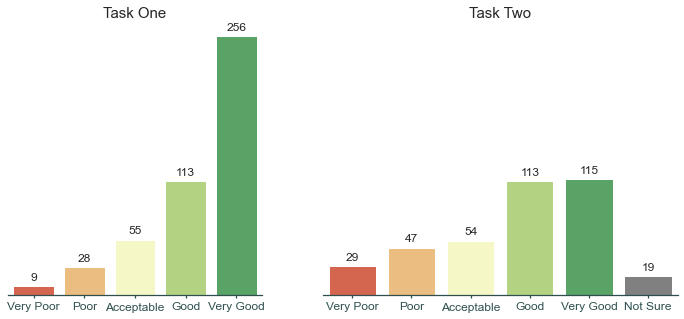

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharey=True, gridspec_kw={'width_ratios': [1, 1.4]})
                               
sns.countplot(x="rating", data=article_evals, order=likert_scale_t1, 
              palette=utils.plotting.signed_discrete_palette, ax=ax1)
ax1.bar_label(ax1.containers[0], padding=4)
ax1.spines["left"].set_visible(False)
ax1.tick_params(axis="y", left=False)
ax1.set_yticklabels([])
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.set_title("Task One", fontsize=15)

palette = utils.plotting.signed_discrete_palette
palette.append("gray")
sns.countplot(x="rating", data=stock_evals, order=likert_scale_t2, 
              palette=palette, ax=ax2)
ax2.bar_label(ax2.containers[0], padding=4)
ax2.spines["left"].set_visible(False)
ax2.tick_params(axis="y", left=False)
ax2.set_yticklabels([])
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.set_title("Task Two", fontsize=15)

plt.show()
fig.savefig(Path(FIGURES_DIR) / "user_study_results.png", dpi=200)

### Optional reasons for Task One

In [14]:
positive_sentiments = article_evals.rating.isin(["Good", "Very Good"])
neutral_sentiments = article_evals.rating.isin(["Acceptable"])
negative_sentiments = article_evals.rating.isin(["Very Poor", "Poor"])

In [15]:
positive_reasons = Counter(optional_reason_factory(article_evals, positive_sentiments))
sorted(positive_reasons.items())

[('optional-reason-1', 108),
 ('optional-reason-2', 105),
 ('optional-reason-3', 107),
 ('optional-reason-4', 107),
 ('optional-reason-5', 26),
 ('optional-reason-6', 4)]

In [16]:
negative_reasons = Counter(optional_reason_factory(article_evals, negative_sentiments))
sorted(negative_reasons.items())

[('optional-reason-1', 10),
 ('optional-reason-2', 14),
 ('optional-reason-3', 15),
 ('optional-reason-4', 14),
 ('optional-reason-5', 1)]

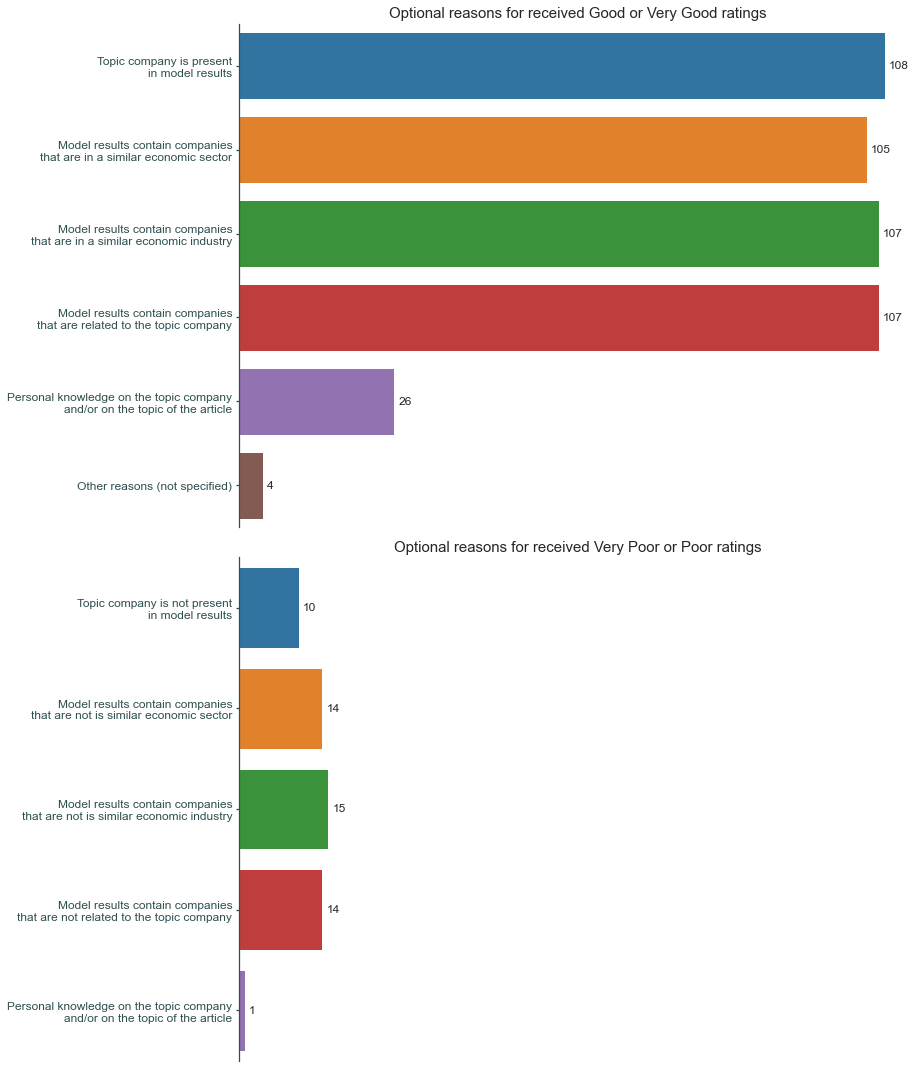

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(13, 15))

pos_optional_reasons = optional_reason_factory(article_evals, positive_sentiments)
sns.countplot(y=sorted(pos_optional_reasons, key=rating_index), 
              palette=utils.plotting.discrete_palette, ax=ax1)
ax1.set_yticklabels(positive_optional_reason_labels)
ax1.bar_label(ax1.containers[0], padding=4)
ax1.spines["bottom"].set_visible(False)
ax1.tick_params(axis="x", bottom=False)
ax1.set_xticklabels([])
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.set_title(r"Optional reasons for received Good or Very Good ratings", fontsize=15)


neg_optional_reasons = optional_reason_factory(article_evals, negative_sentiments)
sns.countplot(y=sorted(neg_optional_reasons, key=rating_index), 
              palette=utils.plotting.discrete_palette, ax=ax2)
ax2.set_yticklabels(negative_optional_reason_labels[:-1])
ax2.bar_label(ax2.containers[0], padding=4)
ax2.spines["bottom"].set_visible(False)
ax2.tick_params(axis="x", bottom=False)
ax2.set_xticklabels([])
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.set_title(r"Optional reasons for received Very Poor or Poor ratings", fontsize=15)

plt.tight_layout()
plt.show()
fig.savefig(Path(FIGURES_DIR) / "article_evaluations_optional_reasons.png", dpi=200)

### Optional reasons for Task Two

In [18]:
t2_optional_reasons = [
    "Irrelevant articles in the relevant column",
    "Relevant articles in the irrelevant column",
    "Topics of articles in the relevant column\nare not about stock sector or industry",
    "Clearly related articles to the stock\nare in the irrelevant column",
    "Personal knowledge on the topic of the stock\nand/or on the topic of the article",
    "Other reasons"
]

In [19]:
Counter(optional_reason_factory(stock_evals))

Counter({'optional-reason-2': 59,
         'optional-reason-1': 28,
         'optional-reason-5': 27,
         'optional-reason-3': 8,
         'optional-reason-4': 1})

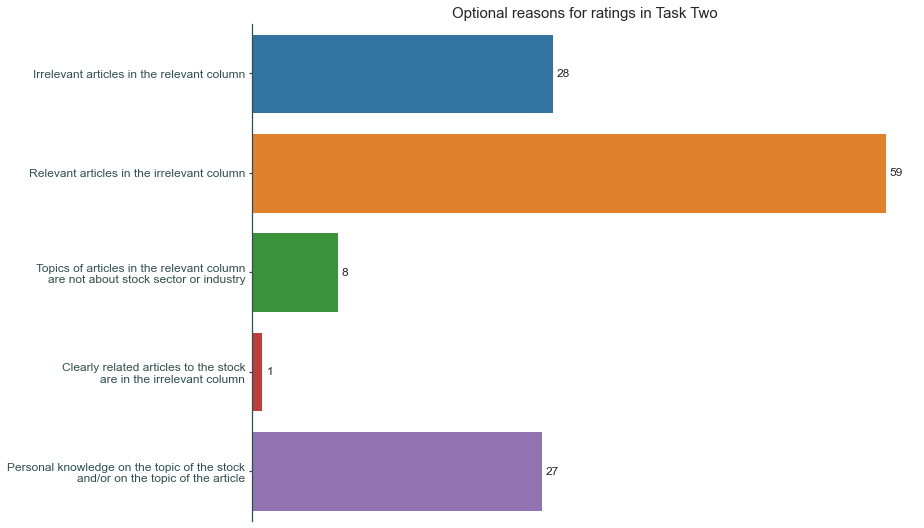

In [20]:
fig, ax = plt.subplots(figsize=(13, 7.5))
sns.countplot(y=sorted(optional_reason_factory(stock_evals), key=rating_index),
              palette=utils.plotting.discrete_palette, ax=ax)
ax.set_yticklabels(t2_optional_reasons[:-1])
ax.bar_label(ax.containers[0], padding=4)
ax.spines["bottom"].set_visible(False)
ax.tick_params(axis="x", bottom=False)
ax.set_xticklabels([])
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.set_title(r"Optional reasons for ratings in Task Two", fontsize=15)

plt.tight_layout()
plt.show()
fig.savefig(Path(FIGURES_DIR) / "stock_evaluations_optional_reasons.png", dpi=200)

#### ``Not Sure`` ratings

In [21]:
stocks = pd.read_json(STOCKS_PATH, lines=True)
display(stocks.head())

,stock_name,ticker_symbol,sector,industry,dbpedia_endpoint,company_name,wiki_page_id,comment
0,21st Century Fox,FOXA,Consumer Services,Broadcasting,http://dbpedia.org/resource/Fox_Corporation,Fox Corporation,58734970,Fox Corporation is an American mass media comp...
1,23andMe Holding Co,ME,Finance,Financial Conglomerates,http://dbpedia.org/resource/23andMe,"23andMe, Inc.",11979083,"23andMe, Inc. is a publicly held personal geno..."
2,2U,TWOU,Technology Services,Packaged Software,http://dbpedia.org/resource/2U_(company),"2U, Inc.",37371846,"2U, Inc. (formerly 2tor Inc.) is an American e..."
3,3M,MMM,Producer Manufacturing,Industrial Conglomerates,http://dbpedia.org/resource/3M,3M Company,7664801,The 3M Company is an American multinational co...
4,Abbott Labs,ABT,Health Technology,Medical Specialties,http://dbpedia.org/resource/Abbott_Laboratories,Abbott Laboratories,488730,Abbott Laboratories is an American multination...


In [22]:
not_sure_stocks = stock_evals[stock_evals.rating == "Not Sure"].ticker_symbol

stocks[stocks.ticker_symbol.isin(not_sure_stocks)] \
    [["stock_name", "ticker_symbol", "sector", "industry"]] \
    .sort_values(["sector", "industry"])

,stock_name,ticker_symbol,sector,industry
596,Roku,ROKU,Consumer Durables,Electronics/Appliances
406,Keurig Dr Pepper,KDP,Consumer Non-Durables,Beverages: Non-Alcoholic
201,Coty,COTY,Consumer Non-Durables,Household/Personal Care
137,Carnival,CCL,Consumer Services,Hotels/Resorts/Cruise lines
492,New Oriental Education & Tech Group,EDU,Consumer Services,Other Consumer Services
303,FuelCell Energy,FCEL,Electronic Technology,Electronic Equipment/Instruments
158,Chevron,CVX,Energy Minerals,Integrated Oil
278,Exxon Mobil,XOM,Energy Minerals,Integrated Oil
413,KKR & Co,KKR,Finance,Investment Managers
86,Banco Santander (Brasil),BSBR,Finance,Regional Banks


### Case example: NIO

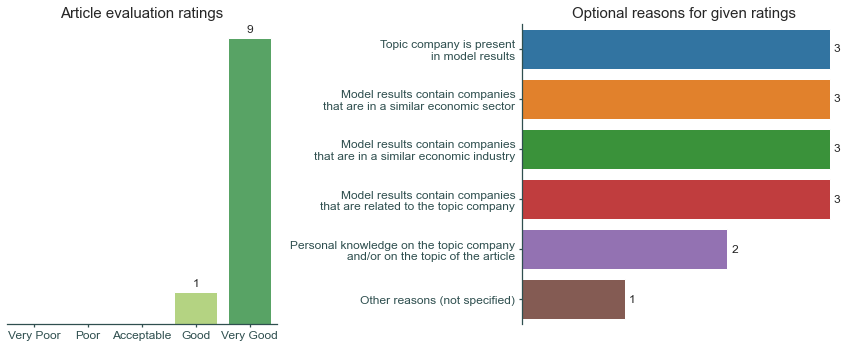

In [25]:
nio_doc_id = "3"
nio_mask = article_evals.doc_id == nio_doc_id
nio_optional_reasons = optional_reason_factory(article_evals, nio_mask)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1.2]})

sns.countplot(x="rating", data=article_evals[nio_mask], order=likert_scale_t1, 
              palette=utils.plotting.signed_discrete_palette, ax=ax1)
ax1.bar_label(ax1.containers[0], padding=4)
ax1.spines["left"].set_visible(False)
ax1.tick_params(axis="y", left=False)
ax1.set_yticklabels([])
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.set_title("Article evaluation ratings", fontsize=15)

sns.countplot(y=nio_optional_reasons, palette=utils.plotting.discrete_palette, ax=ax2)
ax2.set_yticklabels(positive_optional_reason_labels)
ax2.bar_label(ax2.containers[0], padding=4)
ax2.spines["bottom"].set_visible(False)
ax2.tick_params(axis="x", bottom=False)
ax2.set_xticklabels([])
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.set_title("Optional reasons for given ratings", fontsize=15)

fig.tight_layout()
plt.show()

fig.savefig(Path(FIGURES_DIR) / "nio_evaluations.png", dpi=200)